In [1]:
import numpy as np 
import pandas as pd 
import pandas as pd
import missingno as msno
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.stats import kurtosis
import scipy.stats as stats
from sklearn import preprocessing
from scipy.stats import chi2_contingency

In [2]:
hmeq_path = "https://raw.githubusercontent.com/michstg/creditscoring-hmeq-machinelearning-Xtree-KNN/main/hmeq.csv"
data = pd.read_csv(hmeq_path)

In [3]:
data_copy = data.copy()
data_copy.shape

(5960, 13)

In [4]:
data_copy.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


# Meaning of all data fields
* BAD: the target variable, contain binary value 0 or 1, 0-not bad risk (not default). 1-bad risk(default) -> categorical
* LOAN: amount of loan -> mumberical
* MORTDUE: Amount due on the existing mortgage.-> numberical
* VALUE: Current value of the property. -> numberical
* REASON: Reason for the loan request. (HomeImp = home improvement, DebtCon= debt consolidation) -> categorical
* JOB: Six occupational categories. -> categorical
* YOJ: Years at present job. -> numberical
* DEROG: Number of major derogatory reports. -> numberical
* DELINQ: Number of delinquent credit lines. -> numberical
* CLAGE: Age of the oldest credit line in months. -> numberical
* NINQ: Number of recent credit inquiries. -> numberical
* CLNO: Number of existing credit lines. -> numberical
* DEBTINC: Debt-to-income ratio -> numberical

# Check duplicate

In [5]:
data_copy.duplicated(keep=False).sum()

0

# Check missing value

<AxesSubplot:>

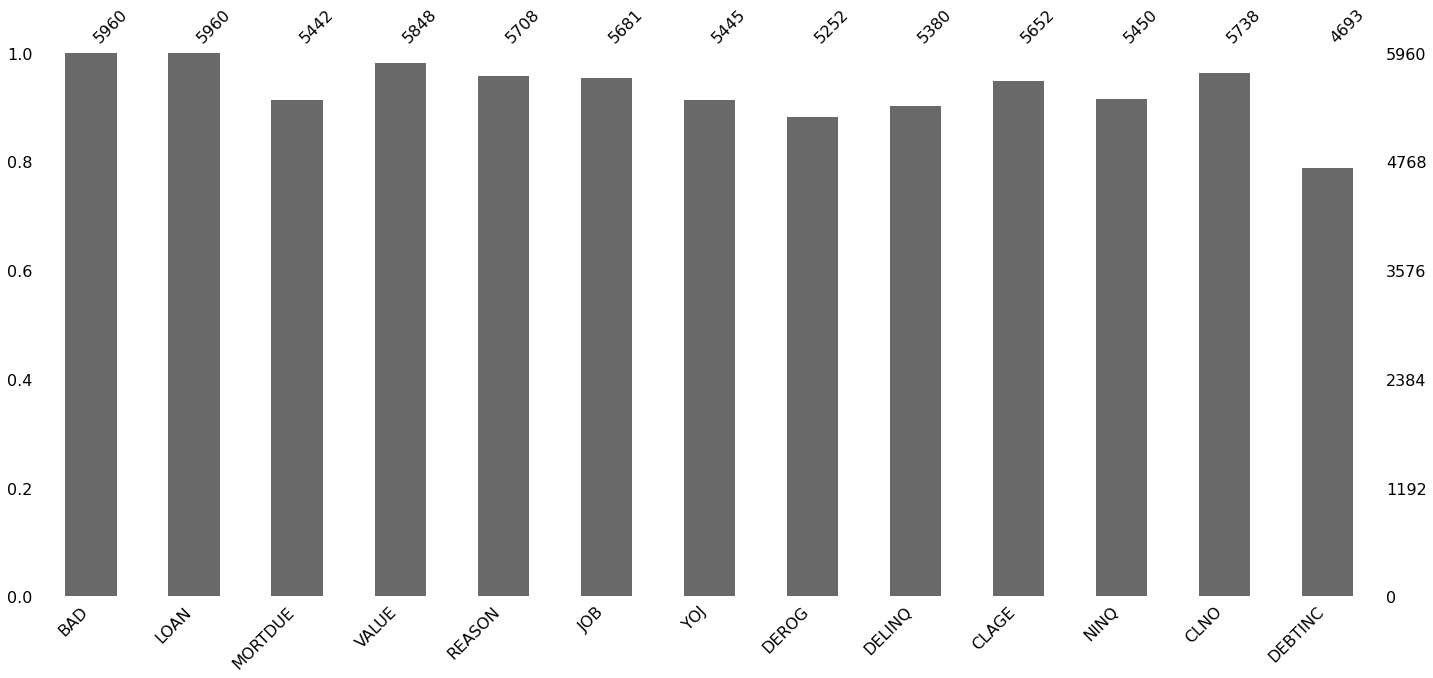

In [6]:
msno.bar(data_copy)

In [7]:
x = data_copy.isnull().sum()/len(data_copy)*100

<AxesSubplot:>

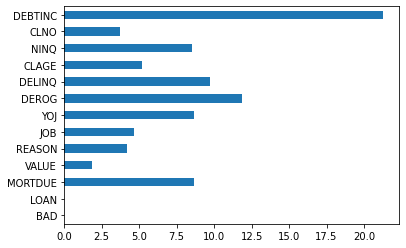

In [8]:
x.plot(kind="barh")

* columns have missing value: 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'
* missing value < 30%

# Type of data

**target variable is BAD column**

In [9]:
data_copy["BAD"].head()

0    1
1    1
2    1
3    1
4    0
Name: BAD, dtype: int64

In [10]:
data_copy["BAD"].value_counts()

0    4771
1    1189
Name: BAD, dtype: int64

<AxesSubplot:>

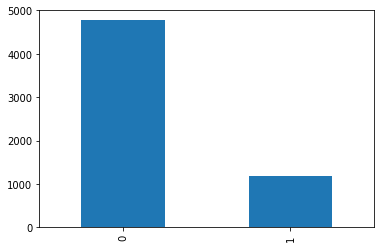

In [11]:
data_copy["BAD"].value_counts().plot(kind="bar")

In [12]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [13]:
data_copy.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

In [14]:
categorical = ['REASON', 'JOB', 'BAD']
numerical = list(set(data_copy.columns) - set(categorical))

In [15]:
print("categorical data: {}".format(categorical))
print("numerical data: {}".format(numerical))

categorical data: ['REASON', 'JOB', 'BAD']
numerical data: ['LOAN', 'YOJ', 'NINQ', 'DEROG', 'VALUE', 'DELINQ', 'MORTDUE', 'DEBTINC', 'CLAGE', 'CLNO']


# Summary of numerical data

In [16]:
data_copy.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


* 'CLNO', 'DEROG', 'DELINQ', 'CLAGE', 'VALUE', 'YOJ', 'MORTDUE', 'NINQ', 'DEBTINC' have count < 5960 -> missing value
* LOAN, MORTDUE, VALUE, DEROG, CLAGE, DELINQ, NINQ, CLNO, DEBTINC have maximun value is quite far from 75th percentile value -> seem skewness.

check normal distribution 

array([[<AxesSubplot:title={'center':'BAD'}>,
        <AxesSubplot:title={'center':'LOAN'}>,
        <AxesSubplot:title={'center':'MORTDUE'}>],
       [<AxesSubplot:title={'center':'VALUE'}>,
        <AxesSubplot:title={'center':'YOJ'}>,
        <AxesSubplot:title={'center':'DEROG'}>],
       [<AxesSubplot:title={'center':'DELINQ'}>,
        <AxesSubplot:title={'center':'CLAGE'}>,
        <AxesSubplot:title={'center':'NINQ'}>],
       [<AxesSubplot:title={'center':'CLNO'}>,
        <AxesSubplot:title={'center':'DEBTINC'}>, <AxesSubplot:>]],
      dtype=object)

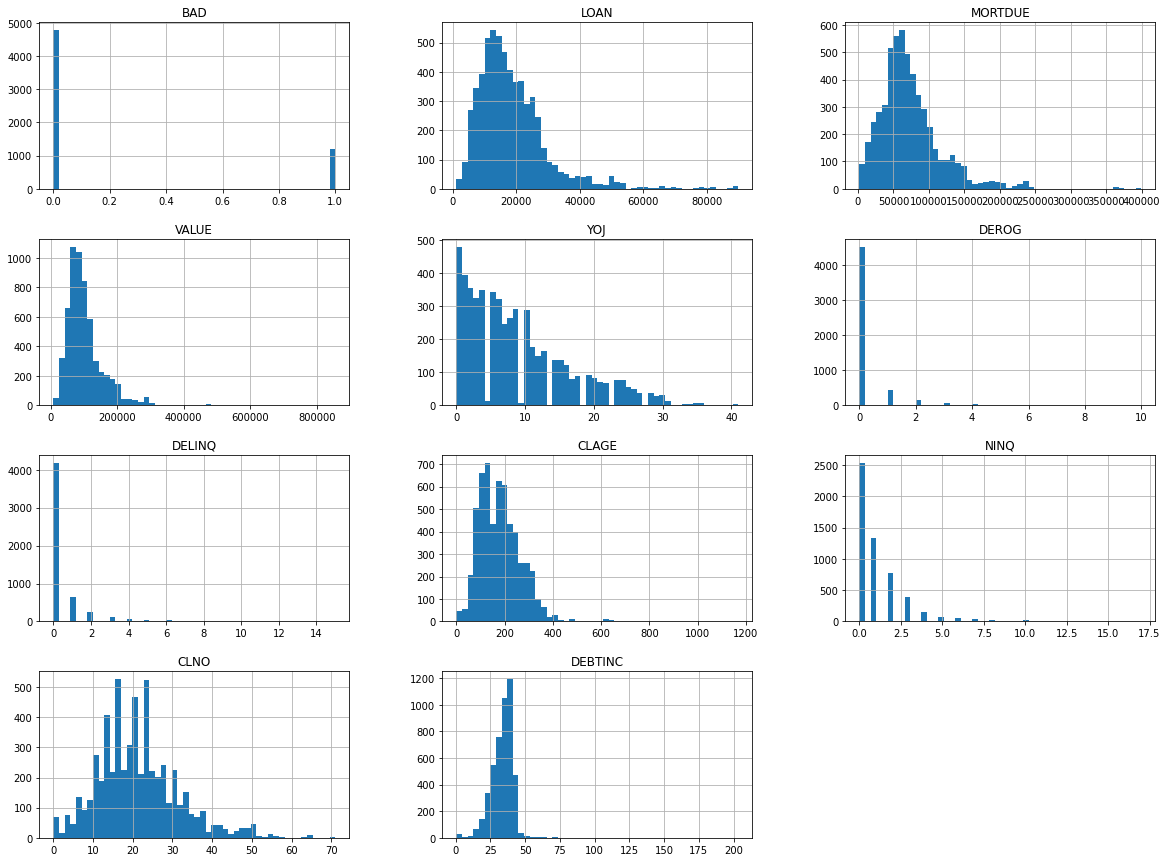

In [17]:
data_copy.hist(bins=50, figsize=(20, 15))

In [18]:
def descriptive_summary_n(data, column_name):
    fig, axs = plt.subplots(1,2, figsize=(19,6))
    axs[0].hist(data[column_name], bins=50) 
    axs[0].axvline(data[column_name].mean(), color='red', label=f"Mean: {round(data[column_name].mean(),2)}") 
    axs[0].axvline(data[column_name].median(), color='green', label=f"Median: {round(data[column_name].median(),2)}") 
    axs[0].axvline(x=data[column_name].describe()[4],color='r', linestyle='--', label=f"25th percentile: {data[column_name].describe()[4]}") 
    axs[0].axvline(x=data[column_name].describe()[6],color='r', linestyle='--', label=f"75th percentile: {data[column_name].describe()[6]}") 
    axs[0].legend()
    sns.boxplot(data=data, x=column_name, ax=axs[1]) #creating boxplot
    axs[1].axvline(data[column_name].mean(), color='red') #vertical line for the mean of the distribution
    fig.suptitle(f"Histogram and Boxplot of {column_name}")
    plt.show()
    
    print(f"{data[column_name].describe().round(3)}\n")
    print(f"Skewness: {skew(data[data[column_name].isna()==False][column_name], bias=True)}")
    print(f"Kurtosis: {kurtosis(data[data[column_name].isna()==False][column_name], bias=True)}")

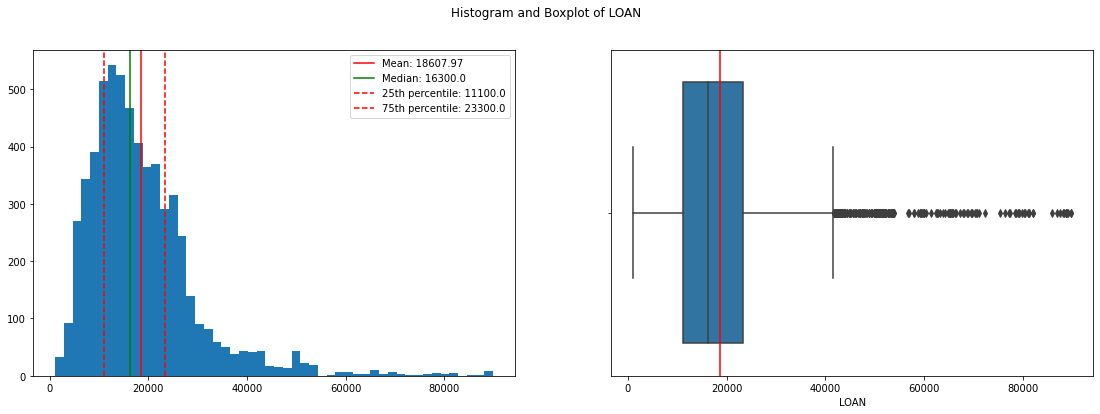

count     5960.00
mean     18607.97
std      11207.48
min       1100.00
25%      11100.00
50%      16300.00
75%      23300.00
max      89900.00
Name: LOAN, dtype: float64

Skewness: 2.023271335267116
Kurtosis: 6.925768660586122


In [19]:
descriptive_summary_n(data_copy, numerical[0])

Data is mostly distributed between 15 and 26. Data distribution is quite similar normal distribution whoes skewness reachs to 0. (0.77)-> don't need modify anything

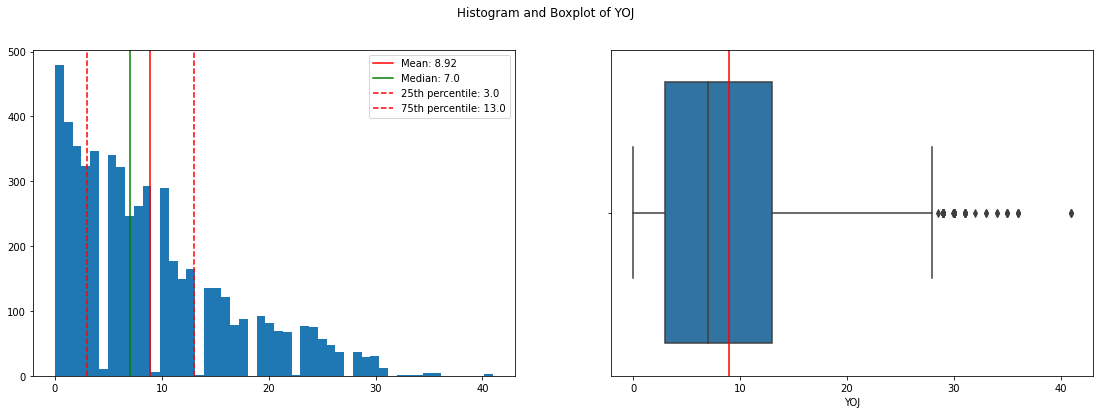

count    5445.000
mean        8.922
std         7.574
min         0.000
25%         3.000
50%         7.000
75%        13.000
max        41.000
Name: YOJ, dtype: float64

Skewness: 0.988187745571414
Kurtosis: 0.37062917639303716


In [20]:
descriptive_summary_n(data_copy, numerical[1])

data is mostly distributed between 29 and 39, some data can be outliers with value > 100. -> clip

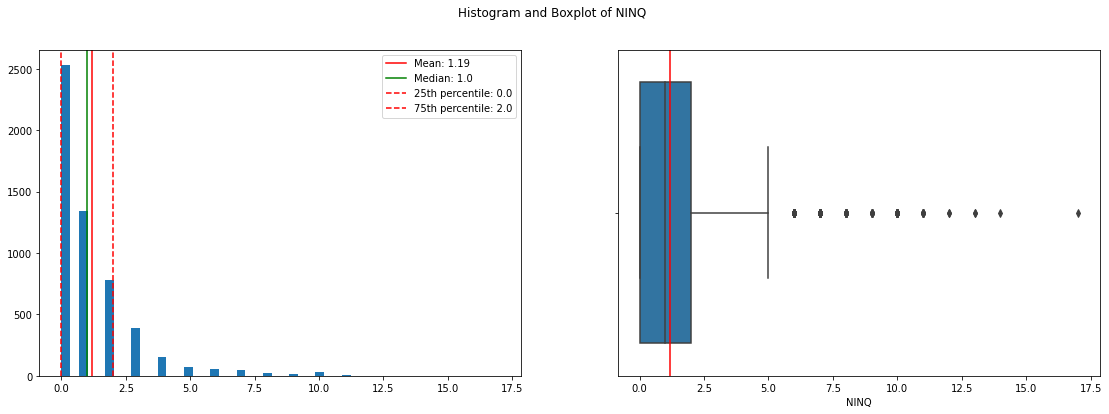

count    5450.000
mean        1.186
std         1.729
min         0.000
25%         0.000
50%         1.000
75%         2.000
max        17.000
Name: NINQ, dtype: float64

Skewness: 2.6212624700635554
Kurtosis: 9.77643042145174


In [21]:
descriptive_summary_n(data_copy, numerical[2])

In [22]:
data_copy["DELINQ"].value_counts()

0.0     4179
1.0      654
2.0      250
3.0      129
4.0       78
5.0       38
6.0       27
7.0       13
8.0        5
10.0       2
11.0       2
15.0       1
12.0       1
13.0       1
Name: DELINQ, dtype: int64

most of values is 0, data contain discrete value from 0 to 13 -> categorical data

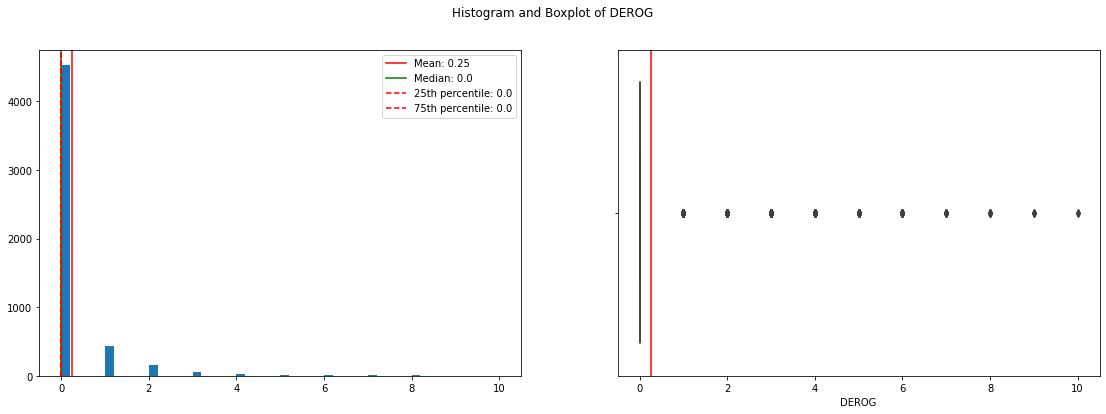

count    5252.000
mean        0.255
std         0.846
min         0.000
25%         0.000
50%         0.000
75%         0.000
max        10.000
Name: DEROG, dtype: float64

Skewness: 5.319350460035318
Kurtosis: 36.83652699472577


In [23]:
descriptive_summary_n(data_copy, numerical[3])

Data is mostly distributed between 46276 to 91488 with mean value 73760. Some cases is outliers with value close to 400000. => clip outliers.

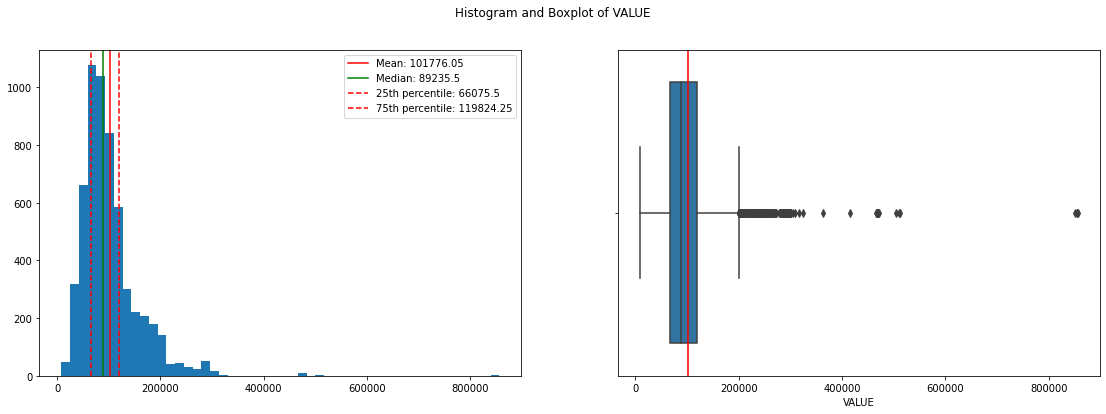

count      5848.000
mean     101776.049
std       57385.775
min        8000.000
25%       66075.500
50%       89235.500
75%      119824.250
max      855909.000
Name: VALUE, dtype: float64

Skewness: 3.052561034173924
Kurtosis: 24.340954016849995


In [24]:
descriptive_summary_n(data_copy, numerical[4])

data mostly distributed in range from 3 to 13. less data point have value close to 40

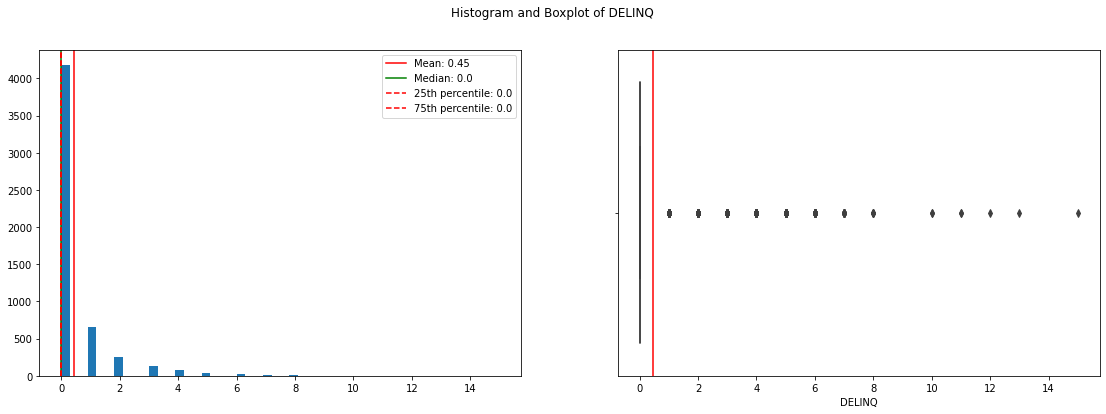

count    5380.000
mean        0.449
std         1.127
min         0.000
25%         0.000
50%         0.000
75%         0.000
max        15.000
Name: DELINQ, dtype: float64

Skewness: 4.022027794361161
Kurtosis: 23.542438371980538


In [25]:
descriptive_summary_n(data_copy, numerical[5])

all value mostly distributed between 15 and 26. close to normal distribution

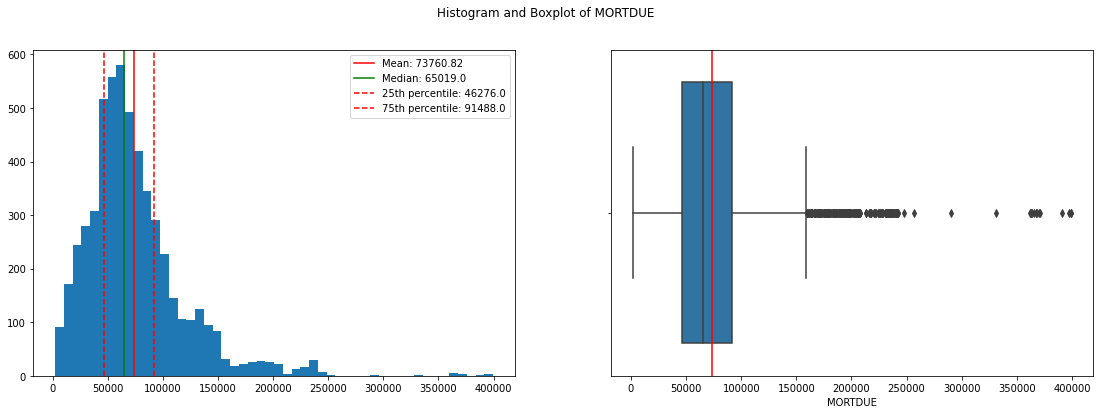

count      5442.000
mean      73760.817
std       44457.609
min        2063.000
25%       46276.000
50%       65019.000
75%       91488.000
max      399550.000
Name: MORTDUE, dtype: float64

Skewness: 1.8139805316190307
Kurtosis: 6.474810104240438


In [26]:
descriptive_summary_n(data_copy, numerical[6])

In [27]:
data_copy["DEROG"].value_counts()

0.0     4527
1.0      435
2.0      160
3.0       58
4.0       23
5.0       15
6.0       15
7.0        8
8.0        6
9.0        3
10.0       2
Name: DEROG, dtype: int64

DEROG have discrete values in few cases, range from 0-10. So, can consider as categorical data.

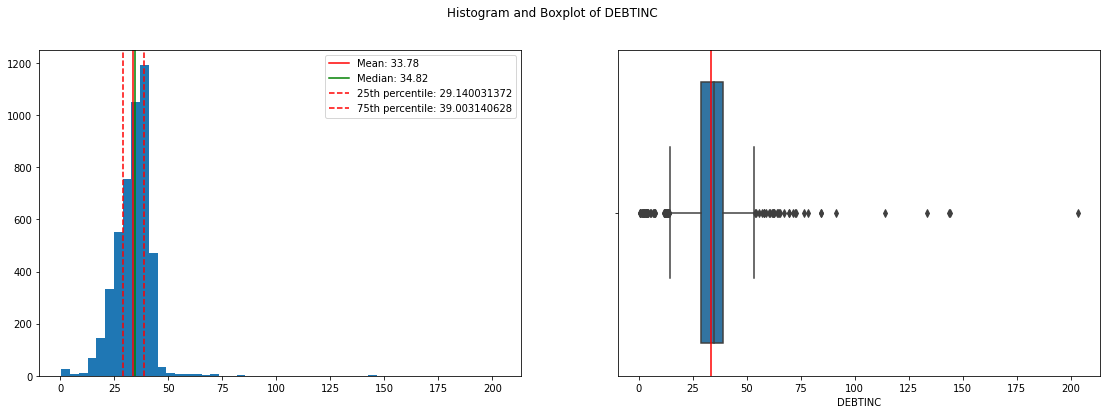

count    4693.000
mean       33.780
std         8.602
min         0.524
25%        29.140
50%        34.818
75%        39.003
max       203.312
Name: DEBTINC, dtype: float64

Skewness: 2.8514416518751813
Kurtosis: 50.44897150965423


In [28]:
descriptive_summary_n(data_copy, numerical[7])

data moslty around 115-231. few value > 600 -> clip

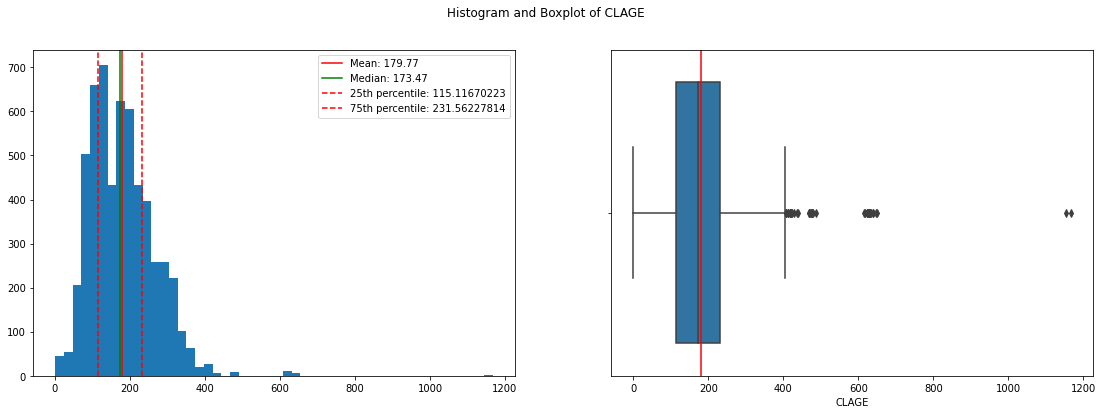

count    5652.000
mean      179.766
std        85.810
min         0.000
25%       115.117
50%       173.467
75%       231.562
max      1168.234
Name: CLAGE, dtype: float64

Skewness: 1.3430554852403158
Kurtosis: 7.591766725791192


In [29]:
descriptive_summary_n(data_copy, numerical[8])

In [30]:
data_copy["NINQ"].value_counts()

0.0     2531
1.0     1339
2.0      780
3.0      392
4.0      156
5.0       75
6.0       56
7.0       44
10.0      28
8.0       22
9.0       11
11.0      10
12.0       2
13.0       2
14.0       1
17.0       1
Name: NINQ, dtype: int64

discrete value from 0 to 17. -> categorical data

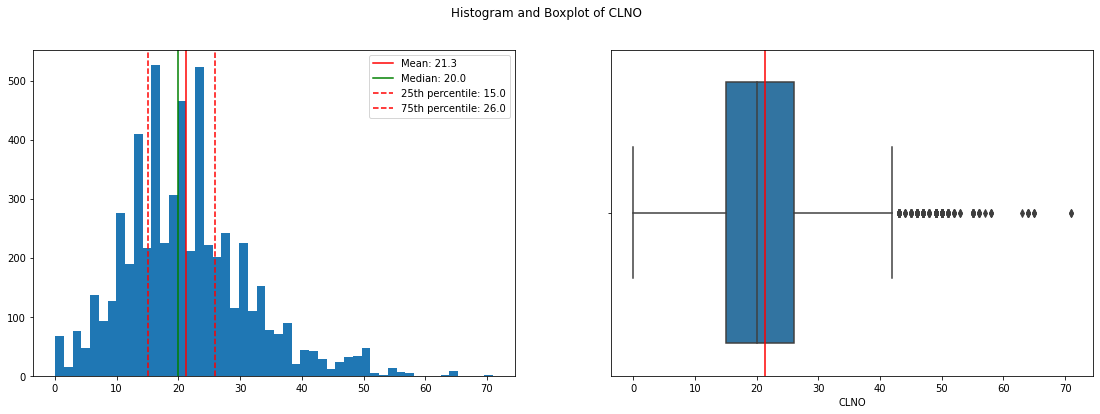

count    5738.000
mean       21.296
std        10.139
min         0.000
25%        15.000
50%        20.000
75%        26.000
max        71.000
Name: CLNO, dtype: float64

Skewness: 0.7748491333266019
Kurtosis: 1.1556187224902832


In [31]:
descriptive_summary_n(data_copy, numerical[9])

data is mostly distributed between 66075 and 119824. few data > 400000 -> clip

# Summary of categorical data

In [32]:
data_c = data.copy()
data_c.loc[data_c['BAD']==0, 'BAD']='Not default'
data_c.loc[data_c['BAD']==1, 'BAD']='Default'

In [33]:
def descriptive_summary_c(data, column_name):
    print(f"\033[1mFrequency table of {column_name} variable: \033[0m")
    freq_table = data[column_name].value_counts().to_frame().reset_index() 
    freq_table.columns = [column_name, 'Frequencies']
    freq_table['% Percentages'] = round(freq_table['Frequencies']/data[column_name].count()*100,2) 
    display(freq_table)
    print()
    fig,axs = plt.subplots(1,2,figsize=(15,5))
    sns.barplot(data=freq_table, x='Frequencies', y=column_name, palette='flare', ax=axs[0]) 
    colors = sns.color_palette('flare')
    d = list(freq_table['% Percentages'])
    labels = list(freq_table[column_name])
    plt.pie(d, labels = labels, colors = colors, autopct='%.0f%%')
    fig.suptitle(f"Bar Chart and Pie Chart of {column_name} variable")
    plt.show()

Frequency table of REASON variable: 


,REASON,Frequencies,% Percentages
0,DebtCon,3928,68.82
1,HomeImp,1780,31.18


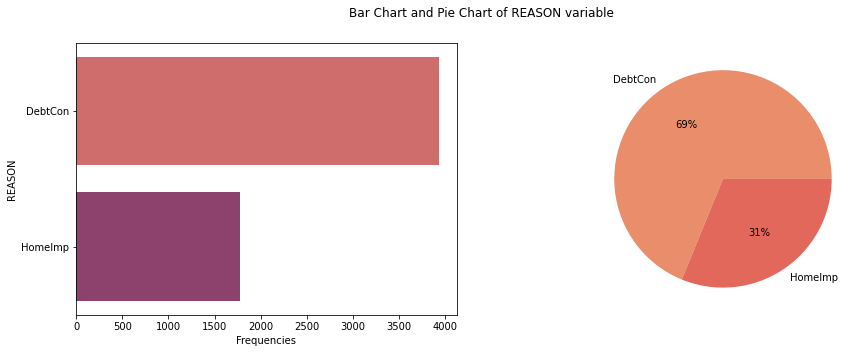

In [34]:
descriptive_summary_c(data_c, categorical[0])

Frequency table of JOB variable: 


,JOB,Frequencies,% Percentages
0,Other,2388,42.03
1,ProfExe,1276,22.46
2,Office,948,16.69
3,Mgr,767,13.50
4,Self,193,3.40
5,Sales,109,1.92


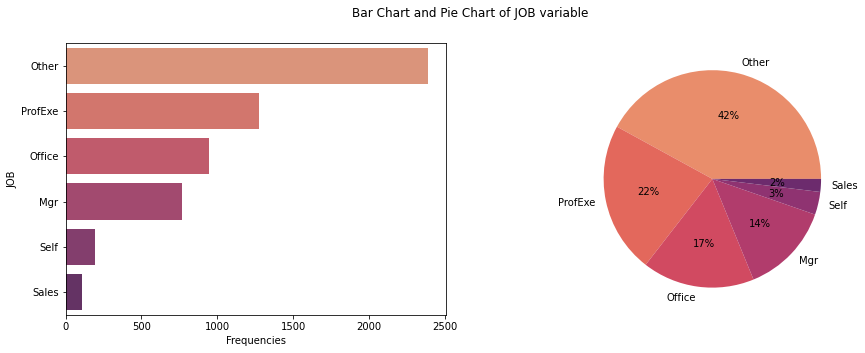

In [35]:
descriptive_summary_c(data_c, categorical[1])

Frequency table of BAD variable: 


,BAD,Frequencies,% Percentages
0,Not default,4771,80.05
1,Default,1189,19.95


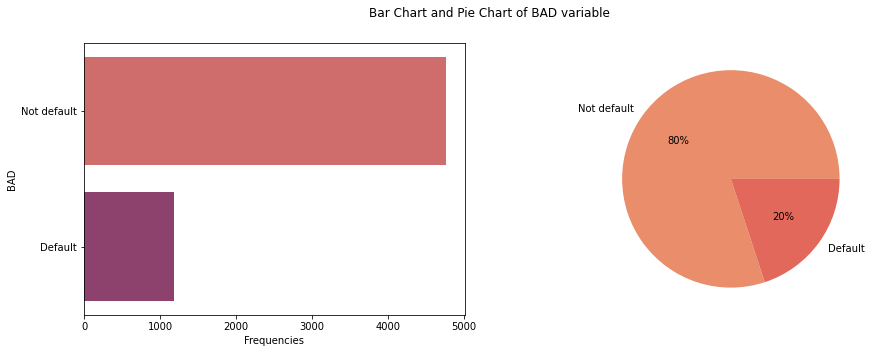

In [36]:
descriptive_summary_c(data_c, categorical[2])

target class is a bit imbalanced.

# Correlation among categorical data

**using cramers'v measure**

In [37]:
label = preprocessing.LabelEncoder() 
data_encoded = pd.DataFrame() 

for i in data_copy[categorical].columns :
    data_encoded[i]=label.fit_transform(data_copy[i])

In [38]:
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] 
    obs = np.sum(crosstab) 
    mini = min(crosstab.shape)-1 
    return (stat/(obs*mini))

In [39]:
rows= []
for var1 in data_encoded:
    col = []
    for var2 in data_encoded :
        cramers =cramers_V(data_encoded[var1], data_encoded[var2])
        col.append(round(cramers,2)) 
    rows.append(col)      
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)
df

,REASON,JOB,BAD
REASON,1.00,0.08,0.00
JOB,0.08,1.00,0.02
BAD,0.00,0.02,1.00


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


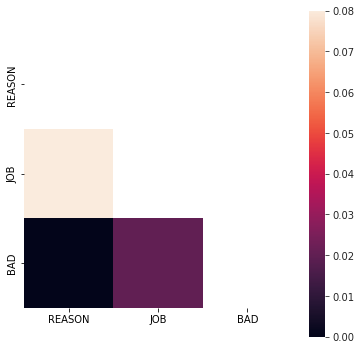

In [40]:
fig, ax = plt.subplots(figsize=(6,6))
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(df, mask=mask, square=True)
plt.show()

# Correlation among numerical data

using pearson measure

In [41]:
data_copy[numerical+["BAD"]].corr(method='pearson')

,LOAN,YOJ,NINQ,DEROG,VALUE,DELINQ,MORTDUE,DEBTINC,CLAGE,CLNO,BAD
LOAN,1.000000,0.105728,0.044487,-0.001302,0.335393,-0.035144,0.228595,0.084735,0.088540,0.072631,-0.075099
YOJ,0.105728,1.000000,-0.071627,-0.065879,0.007759,0.038153,-0.088480,-0.055891,0.201718,0.024838,-0.060238
NINQ,0.044487,-0.071627,1.000000,0.173934,-0.004398,0.067812,0.031392,0.141344,-0.116935,0.088389,0.174980
DEROG,-0.001302,-0.065879,0.173934,1.000000,-0.048689,0.211832,-0.049516,0.017065,-0.083047,0.061884,0.276081
VALUE,0.335393,0.007759,-0.004398,-0.048689,1.000000,-0.014103,0.875666,0.132174,0.171238,0.269149,-0.029954
DELINQ,-0.035144,0.038153,0.067812,0.211832,-0.014103,1.000000,-0.001044,0.052364,0.022488,0.164639,0.354107
MORTDUE,0.228595,-0.088480,0.031392,-0.049516,0.875666,-0.001044,1.000000,0.154939,0.140047,0.323631,-0.048219
DEBTINC,0.084735,-0.055891,0.141344,0.017065,0.132174,0.052364,0.154939,1.000000,-0.046477,0.185539,0.199835
CLAGE,0.088540,0.201718,-0.116935,-0.083047,0.171238,0.022488,0.140047,-0.046477,1.000000,0.237987,-0.170499
CLNO,0.072631,0.024838,0.088389,0.061884,0.269149,0.164639,0.323631,0.185539,0.237987,1.000000,-0.004157


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


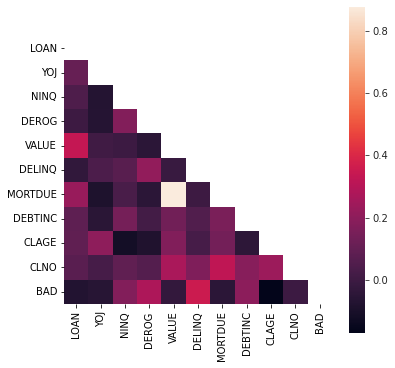

In [42]:
fig, ax = plt.subplots(figsize=(6,6))
mask = np.zeros_like(data_copy[numerical+["BAD"]].corr(method='pearson'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(data_copy[numerical+["BAD"]].corr(method='pearson'), mask=mask, square=True)
plt.show()

* MORTDUE-CLNO, CLAGE-CLNO, VALUE-CLNO, DELINQ-DEROG, CLAGE-YOJ,LOAN-VALUE, LOAN-MORTDUE are a bit positive-correlation
* MORTDUE-VALUE are strong positive-correlation
* correlation with target variable: BAD-DEROG, DELINQ-BAD are a bit positive-correlation

# Weight of evidence - IV

**impute missing data from numerical, categorical data**

In [43]:
data_cop = data.copy()
columns_num = data_cop.select_dtypes(['float', 'int']).columns
data_cop[columns_num] = data_cop[columns_num].apply(lambda x: x.fillna(x.mean()), axis=0)

columns_obj = data_cop.select_dtypes(['object']).columns
data_cop[columns_obj] = data_cop[columns_obj].apply(lambda x: x.fillna('Missing'), axis=0)


In [44]:
def calculate_woe_iv(data, col, target, bins=10):
    if (data[col].dtype.kind in 'bifc') and (len(np.unique(data[col]))>10):
        bin_df = pd.qcut(data[col], bins,  duplicates='drop')
        d0 = pd.DataFrame({'bin range': bin_df, 'y': data[target]})
    else:
        d0 = pd.DataFrame({'bin range': data[col], 'y': data[target]})

    d = d0.groupby("bin range", as_index=False).agg({"y": ["count", "sum"]})
    d.columns = ['bin range', 'num of data', 'Events']

    d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()# avoid 0

    d['Non-Events'] = d['num of data'] - d['Events']

    d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()#avoid 0

    d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
    d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
    d.insert(loc=0, column='col name', value=col)

    return d

calculate_woe_iv(data_cop, "LOAN", "BAD")

,col name,bin range,num of data,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,LOAN,"(1099.999, 7600.0]",603,229,0.192599,374,0.078390,0.898910,0.102663
1,LOAN,"(7600.0, 10000.0]",608,137,0.115223,471,0.098721,0.154566,0.002551
2,LOAN,"(10000.0, 12100.0]",582,106,0.089151,476,0.099769,-0.112535,0.001195
3,LOAN,"(12100.0, 14400.0]",610,107,0.089992,503,0.105429,-0.158318,0.002444
4,LOAN,"(14400.0, 16300.0]",578,131,0.110177,447,0.093691,0.162082,0.002672
5,LOAN,"(16300.0, 18800.0]",604,84,0.070648,520,0.108992,-0.433569,0.016625
6,LOAN,"(18800.0, 21700.0]",591,99,0.083263,492,0.103123,-0.213916,0.004248
7,LOAN,"(21700.0, 25000.0]",613,107,0.089992,506,0.106057,-0.164265,0.002639
8,LOAN,"(25000.0, 30500.0]",576,72,0.060555,504,0.105638,-0.556467,0.025087
9,LOAN,"(30500.0, 89900.0]",595,117,0.098402,478,0.100189,-0.017993,0.000032


In [45]:
def rank_iv(iv):
    if iv <= 0.02:
        return 'Useless'
    elif iv <= 0.1:
        return 'Weak'
    elif iv <= 0.3:
        return 'Medium'
    elif iv <= 0.5:
        return 'Strong'
    else:
        return 'suspicious'
cols_expt_target = list(data.columns.drop(target))
target = "BAD"
IV = []
for col in cols_expt_target:
    IV.append(calculate_woe_iv(data_cop, col, target)["IV"].sum())

res = pd.DataFrame(list(zip(cols_expt_target, IV)), columns=["col name", "IV"])
res["rank"] = res["IV"].apply(rank_iv)
res.sort_values("IV")

NameError: name 'target' is not defined